### 1. Load dataset

In [1]:
dataset_base_path = r'/Users/kripik123/Documents/dataset/processedx/selected_fiture_per-dataset/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from time import time #time stamp for all processing time
from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve, plot_pr_curves, plot_pr_threshold_curves
from ml_ids.prediction import predict_proba_positive, predict_decision_boundary

%matplotlib inline

In [2]:
types = {
    'protocol': 'uint8',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_mean': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_std': 'float32',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_pkts_s': 'float32',
    'fin_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'idle_mean': 'float32',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 2. Preprocessing Data

In [3]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, 'dos-*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097149 entries, 0 to 1048573
Data columns (total 34 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      int64  
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_bwd_pkts    uint32 
 5   fwd_pkt_len_mean   float32
 6   fwd_pkt_len_std    float32
 7   bwd_pkt_len_mean   float32
 8   flow_byts_s        float64
 9   flow_pkts_s        float64
 10  flow_iat_std       float32
 11  flow_iat_min       int64  
 12  fwd_iat_tot        int64  
 13  fwd_iat_min        int64  
 14  bwd_iat_tot        uint32 
 15  bwd_iat_mean       float64
 16  bwd_iat_min        uint32 
 17  fwd_psh_flags      uint8  
 18  fwd_urg_flags      uint8  
 19  bwd_pkts_s         float32
 20  fin_flag_cnt       uint8  
 21  rst_flag_cnt       uint8  
 22  psh_flag_cnt       uint8  
 23  ack_flag_cnt       uint8  
 24  urg_flag_cnt       uint8  
 25  down_up_ratio     

In [5]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

0    fwd_urg_flags
dtype: object

In [6]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

### 2.1. Train / Test split

In order to train and evaluate different models a train/evaluation/test split is created with the ratios of `0.8/0.1/0.1`.  
The split is stratified using the attack category in order to guarantee that all attacks are represented in the training and test set based on their occurences in the dataset.  
To use algorithms expecting categorical values being one-hot-encoded, copies of the training and test data are created (`X_train_oh`, `X_test_oh`) with the feature `protocol` being one-hot-encoded.

In [7]:
## bagi dataset menjadi 80 % untuk training, 20 % untuk evaluasi
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
##X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
##X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [8]:
## hitung jumlah sampel per kategori di dataset
y.label.value_counts()

Benign                      1442849
DoS attacks-Hulk             461912
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
Name: label, dtype: int64

In [9]:
## hitung jumlah sampel y_train 80%
y_train.label.value_counts()

Benign                      1154279
DoS attacks-Hulk             369530
DoS attacks-SlowHTTPTest     111912
DoS attacks-GoldenEye         33206
DoS attacks-Slowloris          8792
Name: label, dtype: int64

In [10]:
## sampel evaluasi 10%
y_eval.label.value_counts()

Benign                      288570
DoS attacks-Hulk             92382
DoS attacks-SlowHTTPTest     27978
DoS attacks-GoldenEye         8302
DoS attacks-Slowloris         2198
Name: label, dtype: int64

In [11]:
## hitung persentasi antara sampel attack dengan benign di y_train
## hasilnya 68% benign, dan sisanya adalah sampel attack

percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    1154279
1     523440
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.6880


In [12]:
y_eval=y_eval.replace({'DoS attacks-Hulk':1, 'DoS attacks-SlowHTTPTest':3, 'DoS attacks-GoldenEye':4, 'DoS attacks-Slowloris':5})
y_train=y_train.replace({'DoS attacks-Hulk':1, 'DoS attacks-SlowHTTPTest':3, 'DoS attacks-GoldenEye':4, 'DoS attacks-Slowloris':5})

In [13]:
class_names=[1,3,4,5]

## 3. Classifier

#### algoritma yang dipake:
- Random forest

In [14]:
scaler = StandardScaler()
scaler.fit(X_train_oh)

StandardScaler(copy=True, with_mean=True, with_std=True)

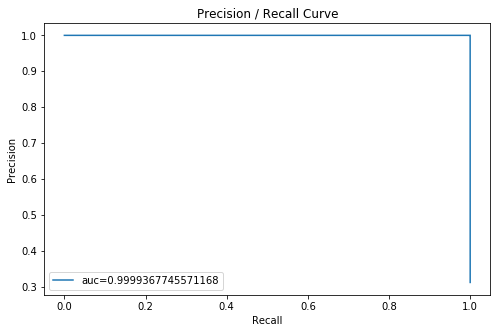

Average PR Score 0.9999367745571168
Time to fit Data Train
0:08:11.50


In [15]:
## 2. RandomForest form scikit-learn with default value
## coba dari source code binary classification

start_time = time()
##cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
##cls_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
cls_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1)
##cls_forest = RandomForestClassifier()
cls_forest.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_rf = predict_proba_positive(cls_forest, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_rf)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    288570
           1      1.000     1.000     1.000    130860

    accuracy                          1.000    419430
   macro avg      1.000     1.000     1.000    419430
weighted avg      1.000     1.000     1.000    419430

Confusion Matrix:


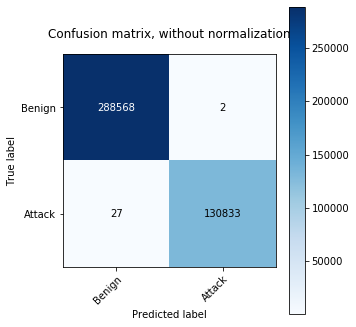

Misclassifications by attack category:


,misclassified,total,percent_misclassified
5,26,2198,0.011829
4,1,8302,0.000120
Benign,2,288570,0.000007


In [16]:
## confusion matrix and missclassification table

pred_val_rf = cls_forest.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_rf)

## 4. Model Save

In [19]:
import joblib as jl
import uuid

##save
model_path = 'models/rf_{}.joblib'.format(uuid.uuid4())
jl.dump(cls_forest, model_path)



['models/rf_2567245d-ddd2-49b2-ab39-9fee04126866.joblib']

## 5. Load and Performance on Test Set

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    288570
           1      1.000     1.000     1.000    130860

    accuracy                          1.000    419430
   macro avg      1.000     1.000     1.000    419430
weighted avg      1.000     1.000     1.000    419430

Confusion Matrix:


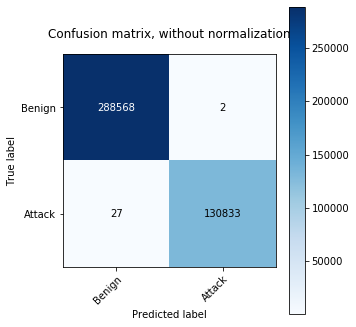

Misclassifications by attack category:


,misclassified,total,percent_misclassified
5,26,2198,0.011829
4,1,8302,0.000120
Benign,2,288570,0.000007


In [22]:
##load
cls_rf = jl.load(model_path)

pred_test_rf = cls_rf.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_test_rf)